In [19]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


faz os dados

In [20]:
# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)


def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4 + np.random.normal(0,1)


z = FrankeFunction(x, y)

Vou plotar a superficie como está no site: https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/chapter3.html#exercises-and-projects

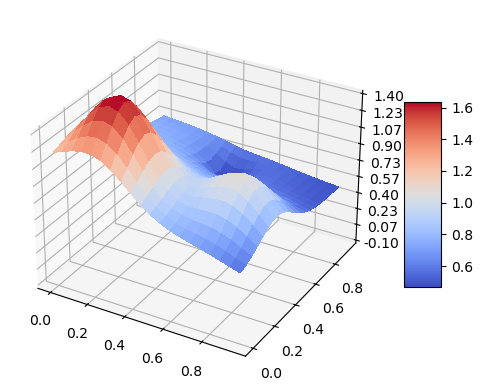

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Exercise: Ordinary Least Square (OLS) on the Franke function

In [22]:
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
z = FrankeFunction(x,y)

x_train,x_test,y_train,y_test,z_train,z_test = train_test_split(x,y,z,train_size=.7,random_state=5)